# MNIST classification

In [1]:
import os
os.environ["KMP_WARNINGS"] = "0"
import numpy as np
import jax.numpy as jnp
import jax
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *
import quimb.tensor as qtn

from tn4ml.initializers import *
from tn4ml.models.mps import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.metrics import *
from tn4ml.strategy import *
from tn4ml.util import *
from tn4ml.eval import *

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')

### Load dataset

**MNIST images** &rarr; grayscale images
- size: 28x28
- 0-9 numbers

In [3]:
train, test = mnist.load_data()

In [4]:
train_labels = train[1]
train_images = train[0].reshape(-1, 28, 28)

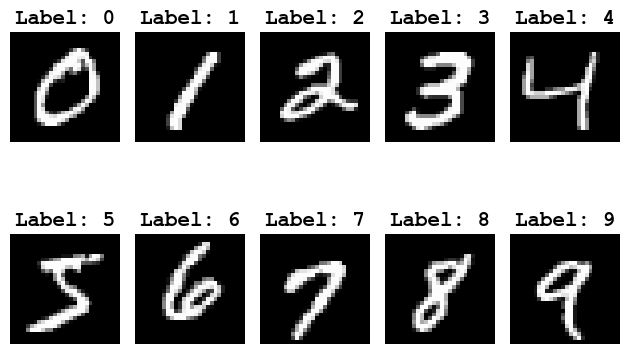

In [5]:
import matplotlib.pyplot as plt
hfont = {'fontname':'Courier New', 'fontsize': 15, 'fontweight': 'bold'}

for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Select the first image of each digit
    digit_indices = np.where(train_labels == i)[0]
    plt.imshow(train_images[digit_indices[0]], cmap='gray')
    plt.title(f'Label: {i}', **hfont)
    plt.axis('off')

plt.tight_layout()

In [6]:
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

**Reduce size of the image**

In [7]:
def resize_images(images):
    resized_images = tf.image.resize(images, [14, 14], method=tf.image.ResizeMethod.AREA)
    return resized_images.numpy()

In [8]:
X_resized = resize_images(data['X']['train'].reshape(-1,28,28,1)).reshape(-1,14,14)/255.0

X_test_resized = resize_images(data['X']['test'].reshape(-1,28,28,1)).reshape(-1,14,14)/255.0

### Rearagne pixels in zig-zag order
- (from https://arxiv.org/pdf/1605.05775.pdf)

<img src="images/zig-zag.png" alt="MPS Params" width="150" height="150">

In [9]:
def zigzag_order(data):
    data_zigzag = []
    for x in data:
        image = []
        for i in x:
            image.extend(i)
        data_zigzag.append(image)
    return np.asarray(data_zigzag)

In [10]:
train_data = zigzag_order(X_resized)
test_data = zigzag_order(X_test_resized)

### One-hot encoding of labels

0 &rarr; [1 0 0 0 0 0 0 0 0 0]<br>
1 &rarr; [0 1 0 0 0 0 0 0 0 0]<br>
<br>
....<br>
<br>
9 &rarr; [0 0 0 0 0 0 0 0 0 1]<br>

In [11]:
n_classes = 10

In [12]:
y_train = integer_to_one_hot(data['y']['train'], n_classes)
y_test = integer_to_one_hot(data['y']['test'], n_classes)

**Take samples for training, validation and testing**

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_inputs, _, train_targets, _ = train_test_split(train_data, y_train, test_size=0.9, random_state=42) # take only 10% of the training data - to speed up the training

In [15]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(train_inputs, train_targets, test_size=0.2, random_state=42)

## TN as ML model
**Specify parameters and initialize a tensor network**

<img src="images/mps_params.png" alt="MPS Params" width="500" height="300">

In [16]:
L = 14*14 # number of tensors in the MPS
initializer = randn(1e-2) # MPS tensors are initialized with random normal values
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 10 # bond dimension of the MPS
phys_dim = 3 # when polyomial embedding is used p = 3, when trigonometric embedding is used p = 2
class_dim = 10 # number of classes
index_class = L//2 if L%2==0 else L//2+1
cyclic = False
add_identity = True
boundary = 'obc' # open boundary conditions

In [17]:
model = MPS_initialize(L,
                    initializer=initializer,
                    key=key,
                    shape_method=shape_method,
                    bond_dim=bond_dim,
                    phys_dim=phys_dim,
                    cyclic=False,
                    add_identity=add_identity,
                    class_dim=class_dim,
                    class_index=index_class,
                    canonical_center=index_class,
                    boundary=boundary,
                    dtype=jnp.float64)

**Define training parameters**

In [18]:
def cross_entropy_loss(*args, **kwargs):
    return OptaxWrapper(optax.softmax_cross_entropy)(*args, **kwargs).mean()

In [19]:
# training parameters
optimizer = optax.adam
strategy = 'global' # Global Gradient Descent
loss = cross_entropy_loss
train_type = TrainingType.SUPERVISED
embedding = PolynomialEmbedding(degree=2, n=1, include_bias=True) # if using randn
learning_rate = 1e-3
device = 'cpu'

In [20]:
model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate, device=device)

In [21]:
epochs = 50
batch_size = 1000

To obtain loss scalar value, contract:

<div style="text-align: center;">
    <img src="images/mps_models.png" alt="MPS Params" width="150" height="250">
</div>

In [22]:
history = model.train(train_inputs,
                    targets = train_targets,
                    val_inputs = val_inputs,
                    val_targets = val_targets,
                    epochs = epochs,
                    batch_size = batch_size,
                    canonize = (True, index_class),
                    embedding = embedding,
                    normalize = True,
                    display_val_acc=True,
                    val_batch_size=batch_size,
                    eval_metric = cross_entropy_loss,
                    dtype = jnp.float64)

epoch: 100%|██████████ 50/50 , loss=1.4784, val_loss=1.5175, val_acc=0.9350


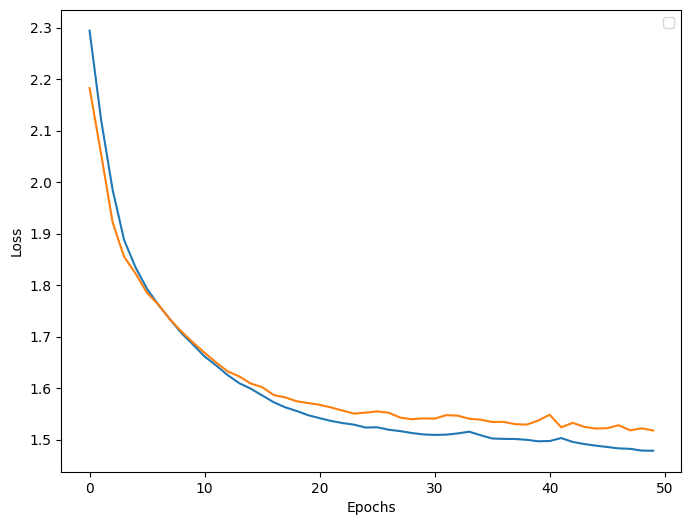

In [23]:
plot_loss(history, validation=True, figsize=(8, 6))

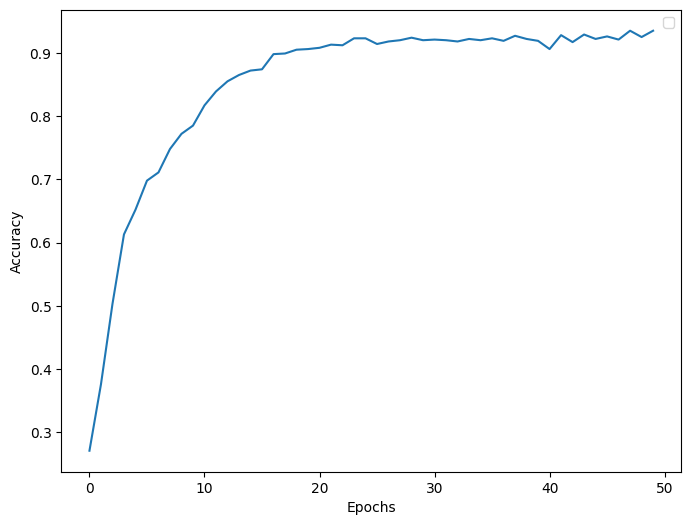

In [24]:
plot_accuracy(history, figsize=(8, 6))

**Save model**

In [27]:
model.save('model', 'results/mnist_class', tn=True) # tn=True because MPS for classification if TensorNetwork object

**Evaluate**

Calculate accuracy of the classification

In [28]:
model.accuracy(test_data, y_test, embedding=embedding, batch_size=512)

0.9369860197368421

### Retrain with exponential decay

In [29]:
# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=1000,
    decay_rate=0.01)

# Combining gradient transforms using `optax.chain`.
gradient_transforms = [
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
]

In [30]:
model.configure(gradient_transforms=gradient_transforms, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [31]:
epochs = 50
batch_size = 1000

In [32]:
history = model.train(train_inputs,
                    targets = train_targets,
                    val_inputs = val_inputs,
                    val_targets = val_targets,
                    epochs = epochs,
                    batch_size = batch_size,
                    canonize = (True, index_class),
                    embedding = embedding,
                    normalize = True,
                    display_val_acc=True,
                    eval_metric = cross_entropy_loss,
                    val_batch_size=batch_size,
                    dtype = jnp.float64)

epoch: 100%|██████████ 50/50 , loss=1.4502, val_loss=1.5027, val_acc=0.9370


In [33]:
model.accuracy(test_data, y_test, embedding=embedding, batch_size=1000)

0.9459